# Alzheimer's Disease Prediction - Model Training and Evaluation

This notebook focuses on training and evaluating various machine learning models for Alzheimer's disease prediction using the engineered features from previous notebooks.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
import xgboost as xgb
from catboost import CatBoostClassifier

# Set plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# For displaying plots inline
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading

In [2]:
# Load datasets from both feature engineering approaches
# First approach: Statistical feature selection
data_statistical = pd.read_csv('fe_statistical_approach.csv')
print(f"Loaded statistical approach dataset with shape: {data_statistical.shape}")

# Second approach: Model-based feature selection
data_model_based = pd.read_csv('fe_model_based_approach.csv')
print(f"Loaded model-based approach dataset with shape: {data_model_based.shape}")

datasets_loaded = True


Loaded statistical approach dataset with shape: (74283, 24)
Loaded model-based approach dataset with shape: (74283, 20)


In [3]:
# If feature-engineered datasets are not available, load the preprocessed dataset
if not datasets_loaded:
    # Use the preprocessing code from the feature engineering notebooks
    data_encoded = raw_data.copy()
    
    # Define feature categories
    numerical_features = ['Age', 'Education Level', 'BMI', 'Cognitive Test Score']
    binary_features = [
        'Gender', 'Diabetes', 'Hypertension', 'Cholesterol Level',
        'Family History of Alzheimer’s', 'Genetic Risk Factor (APOE-ε4 allele)',
        'Urban vs Rural Living', "Alzheimer’s Diagnosis"
    ]
    ordinal_features = [
        'Physical Activity Level', 'Depression Level', 'Sleep Quality',
        'Dietary Habits', 'Air Pollution Exposure', 'Social Engagement Level',
        'Income Level', 'Stress Levels', 'Smoking Status', 'Alcohol Consumption'
    ]
    categorical_features = [col for col in data_encoded.columns if col not in numerical_features]
    nominal_features = [col for col in categorical_features 
                        if col not in binary_features and col not in ordinal_features]
    
    # Binary encoding
    for col in binary_features:
        data_encoded[col] = data_encoded[col].astype(str).str.lower().map({
            'no': 0, 'yes': 1, 'female': 0, 'male': 1,
            'normal': 0, 'high': 1, 'rural': 0, 'urban': 1
        })
    
    # Ordinal encoding
    ordinal_mappings = {
        'Physical Activity Level': {'low': 0, 'medium': 1, 'high': 2},
        'Depression Level': {'low': 0, 'medium': 1, 'high': 2},
        'Sleep Quality': {'poor': 0, 'average': 1, 'good': 2},
        'Dietary Habits': {'unhealthy': 0, 'average': 1, 'healthy': 2},
        'Air Pollution Exposure': {'low': 0, 'medium': 1, 'high': 2},
        'Social Engagement Level': {'low': 0, 'medium': 1, 'high': 2},
        'Income Level': {'low': 0, 'medium': 1, 'high': 2},
        'Stress Levels': {'low': 0, 'medium': 1, 'high': 2},
        'Smoking Status': {'never': 0, 'former': 1, 'current': 2},
        'Alcohol Consumption': {'never': 0, 'occasionally': 1, 'regularly': 2}
    }
    
    for col, mapping in ordinal_mappings.items():
        if col in data_encoded.columns:
            data_encoded[col] = data_encoded[col].astype(str).str.lower().map(mapping)
    
    # One-hot encoding for nominal features
    data_encoded = pd.get_dummies(data_encoded, columns=nominal_features, drop_first=True)
    
    # Standardize numerical features
    scaler = StandardScaler()
    data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])
    
    # Create feature interactions
    data_encoded['Age_x_APOE'] = data_encoded['Age'] * data_encoded['Genetic Risk Factor (APOE-ε4 allele)']
    
    # Use the encoded dataset
    data_statistical = data_encoded.copy()
    data_model_based = data_encoded.copy()
    
    print(f"Created preprocessed dataset with shape: {data_encoded.shape}")

In [4]:
# Display the first few rows of each dataset
print("Statistical approach dataset:")
print(data_statistical.head())

print("\nModel-based approach dataset:")
print(data_model_based.head())

Statistical approach dataset:
   Country_Russia  Country_USA  Country_South Africa  Risk_Factor_Count  \
0           False        False                 False                  0   
1           False        False                 False                  0   
2           False        False                  True                  1   
3           False        False                 False                  1   
4           False        False                 False                  1   

   Country_India  Country_Mexico  Country_Sweden  Country_Brazil  \
0          False           False           False           False   
1          False           False           False           False   
2          False           False           False           False   
3          False           False           False           False   
4          False           False            True           False   

   Genetic Risk Factor (APOE-ε4 allele)  FamilyHistory_x_APOE  ...  \
0                                     0 

## 2. Data Preparation for Modeling

In [5]:
# Function to prepare data for modeling
def prepare_data(data):
    # Separate features and target
    X = data.drop(columns=["Alzheimer's Diagnosis"])
    y = data["Alzheimer's Diagnosis"]

    # Split data into training, validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Prepare data for both approaches
X_train_stat, X_val_stat, X_test_stat, y_train_stat, y_val_stat, y_test_stat = prepare_data(data_statistical)
X_train_model, X_val_model, X_test_model, y_train_model, y_val_model, y_test_model = prepare_data(data_model_based)

print("Statistical approach:")
print(f"Training set: {X_train_stat.shape}, Validation set: {X_val_stat.shape}, Test set: {X_test_stat.shape}")
print(f"Class distribution in training set: {np.bincount(y_train_stat)}")

print("\nModel-based approach:")
print(f"Training set: {X_train_model.shape}, Validation set: {X_val_model.shape}, Test set: {X_test_model.shape}")
print(f"Class distribution in training set: {np.bincount(y_train_model)}")

Statistical approach:
Training set: (44569, 23), Validation set: (14857, 23), Test set: (14857, 23)
Class distribution in training set: [26142 18427]

Model-based approach:
Training set: (44569, 19), Validation set: (14857, 19), Test set: (14857, 19)
Class distribution in training set: [26142 18427]


## 3. Initial Model Training and Evaluation

In [6]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': LinearSVC(random_state=42, max_iter=2000),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}

# Define evaluation metrics
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [7]:
models.items()

dict_items([('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)), ('Decision Tree', DecisionTreeClassifier(random_state=42)), ('Random Forest', RandomForestClassifier(random_state=42)), ('Gradient Boosting', GradientBoostingClassifier(random_state=42)), ('SVM', LinearSVC(max_iter=2000, random_state=42)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=N

In [8]:
# Function to evaluate models using cross-validation
def evaluate_models(X, y, models, scoring, cv=5):
    results = {}
    for name, model in models.items():
        print(f"Evaluating {name}...")
        
        # Special handling for LinearSVC which doesn't have predict_proba
        if isinstance(model, LinearSVC):
            from sklearn.metrics import make_scorer
            
            # Create custom scorer for LinearSVC using decision_function
            def linearSVC_roc_auc(clf, X, y):
                return roc_auc_score(y, clf.decision_function(X))
                
            custom_scorers = {
                'accuracy': 'accuracy',
                'precision': 'precision',
                'recall': 'recall', 
                'f1': 'f1',
                'roc_auc': make_scorer(linearSVC_roc_auc)
            }
            
            cv_results = cross_validate(
                model, X, y, cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
                scoring=custom_scorers, return_train_score=False
            )
        else:
            # Regular evaluation for other models
            cv_results = cross_validate(
                model, X, y, cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
                scoring=scoring, return_train_score=False
            )
        
        # Get mean and std of each metric (rest of function stays the same)
        metric_results = {}
        for metric in scoring:
            metric_key = f'test_{metric}'
            mean_score = np.mean(cv_results[metric_key])
            std_score = np.std(cv_results[metric_key])
            metric_results[metric] = (mean_score, std_score)
        
        results[name] = metric_results
        
        # Print results
        print(f"{name} Performance:")
        for metric, (mean, std) in metric_results.items():
            print(f"  {metric.capitalize()}: {mean:.4f} ± {std:.4f}")
        print("-" * 50)
    
    return results

### 3.1 Evaluate Models on Statistical Approach Dataset

In [9]:
# Evaluate models using statistical approach features
print("Evaluating models on statistical approach dataset...")
results_stat = evaluate_models(X_train_stat, y_train_stat, models, scoring)

Evaluating models on statistical approach dataset...
Evaluating Logistic Regression...
Logistic Regression Performance:
  Accuracy: 0.7157 ± 0.0048
  Precision: 0.6711 ± 0.0070
  Recall: 0.6129 ± 0.0078
  F1: 0.6407 ± 0.0062
  Roc_auc: 0.7908 ± 0.0025
--------------------------------------------------
Evaluating Decision Tree...
Decision Tree Performance:
  Accuracy: 0.6396 ± 0.0022
  Precision: 0.5635 ± 0.0023
  Recall: 0.5692 ± 0.0063
  F1: 0.5663 ± 0.0040
  Roc_auc: 0.6293 ± 0.0025
--------------------------------------------------
Evaluating Random Forest...
Random Forest Performance:
  Accuracy: 0.7060 ± 0.0031
  Precision: 0.6511 ± 0.0043
  Recall: 0.6222 ± 0.0054
  F1: 0.6363 ± 0.0040
  Roc_auc: 0.7760 ± 0.0010
--------------------------------------------------
Evaluating Gradient Boosting...
Gradient Boosting Performance:
  Accuracy: 0.7276 ± 0.0029
  Precision: 0.6625 ± 0.0042
  Recall: 0.6957 ± 0.0044
  F1: 0.6787 ± 0.0031
  Roc_auc: 0.8034 ± 0.0020
--------------------------

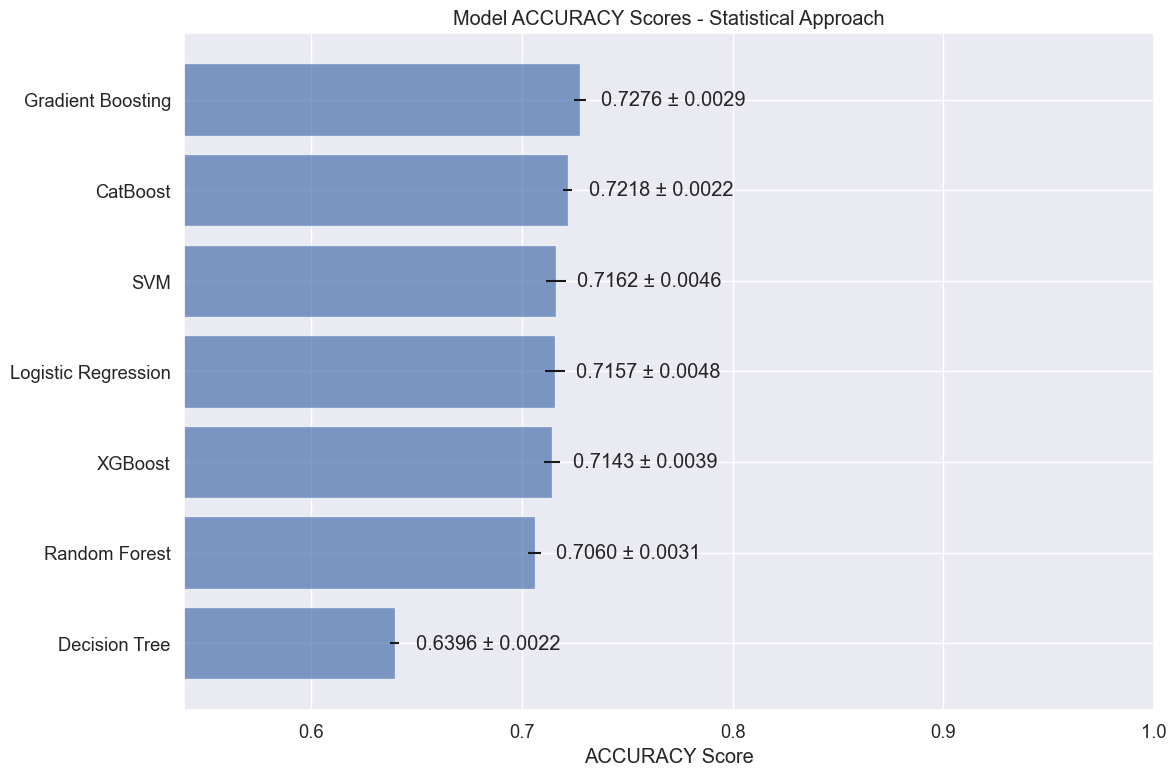

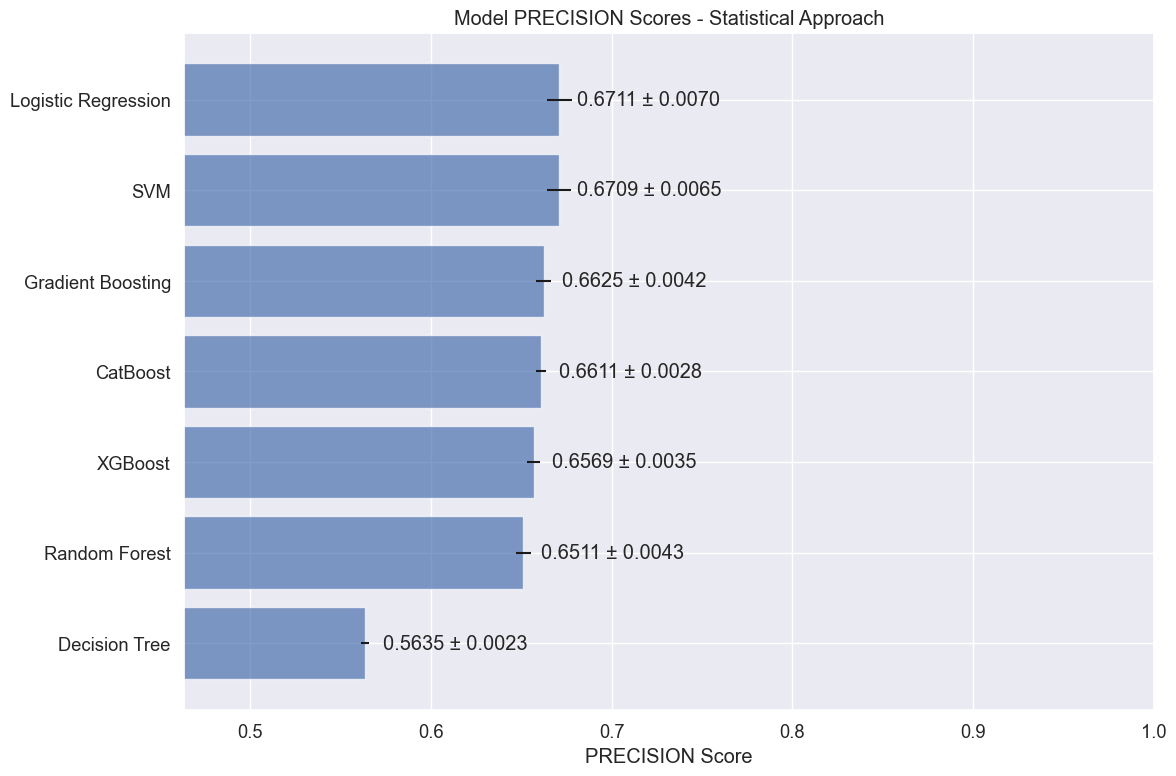

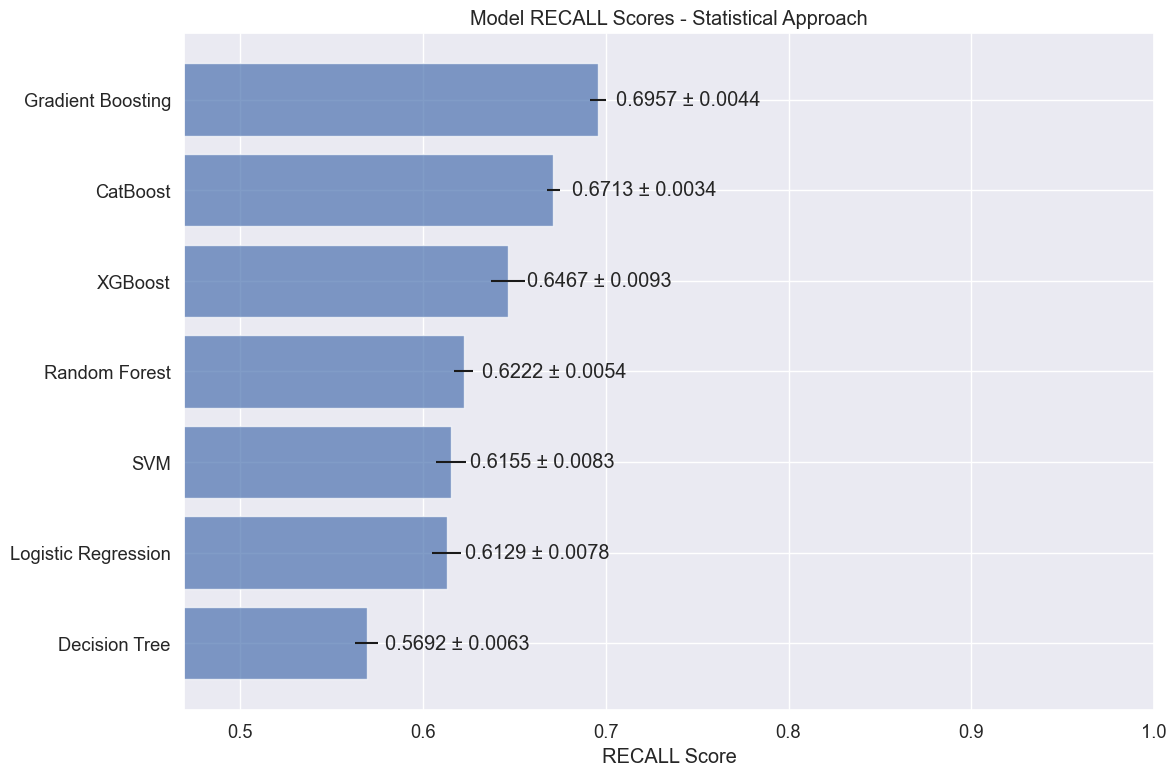

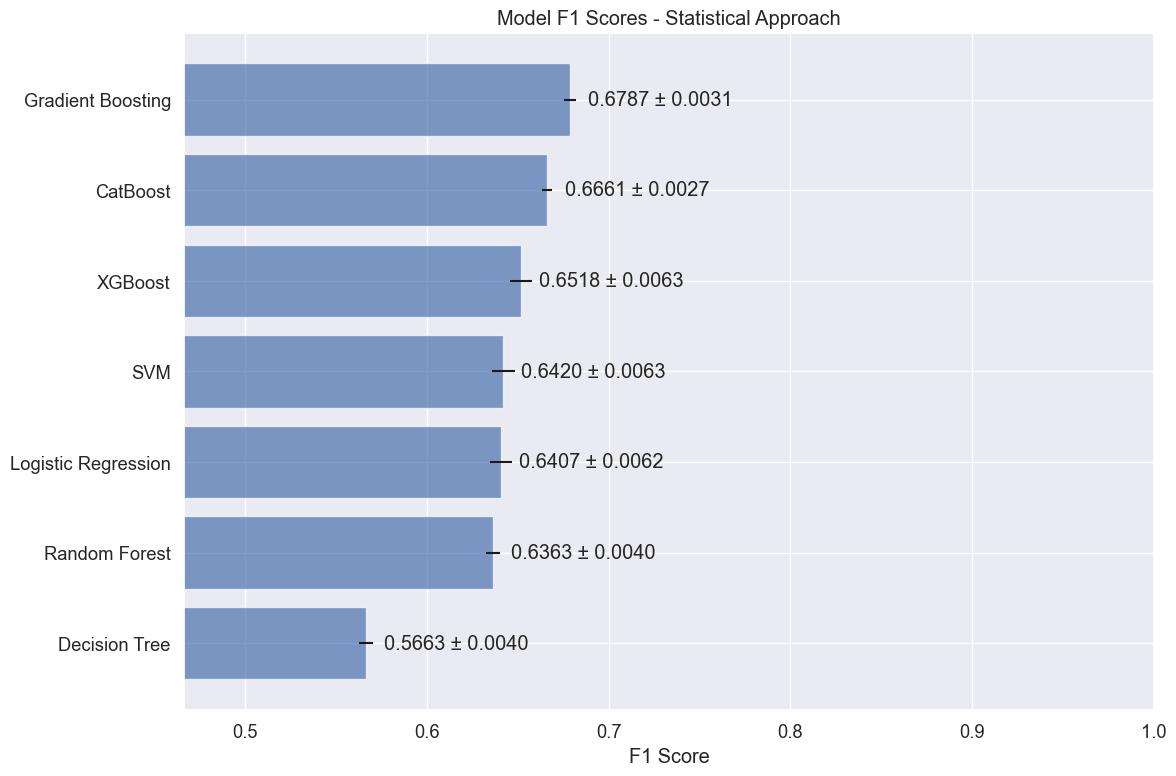

posx and posy should be finite values
posx and posy should be finite values


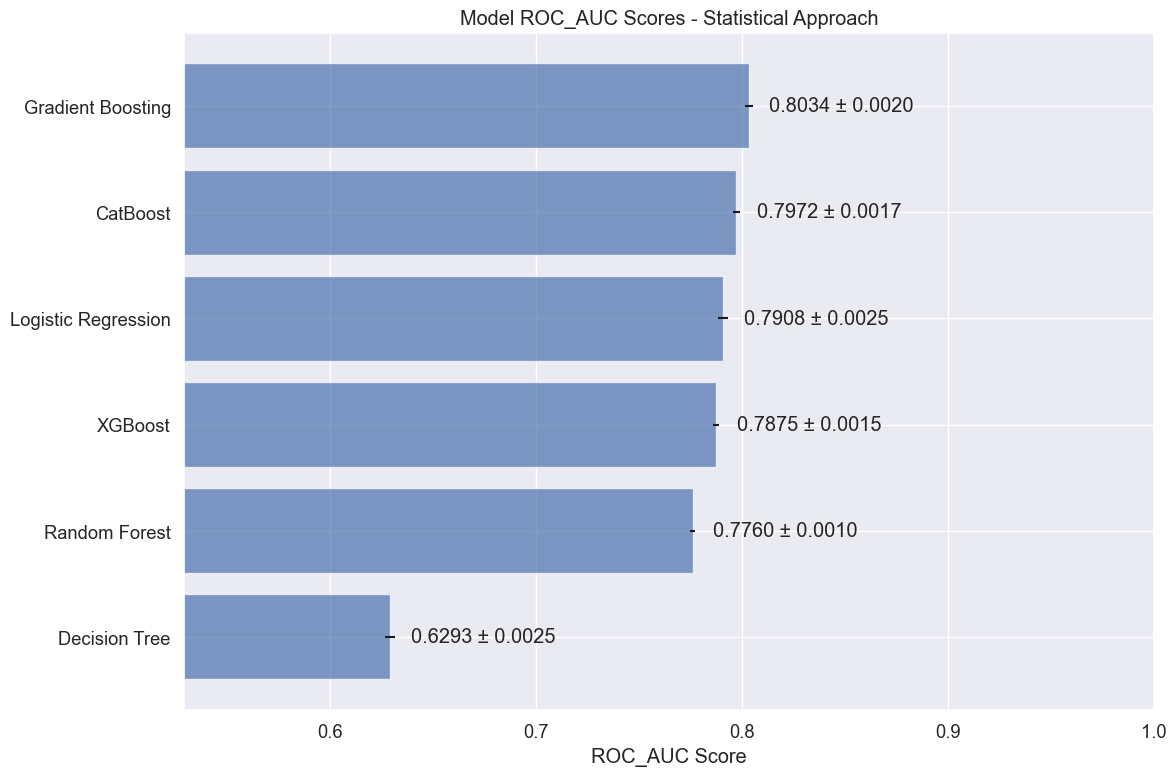

In [10]:
# Visualize results for statistical approach
def plot_model_comparison(results, metric='roc_auc', title="Model Comparison"):
    model_names = list(results.keys())
    mean_scores = [results[model][metric][0] for model in model_names]
    std_scores = [results[model][metric][1] for model in model_names]

    # Sort models by mean score
    sorted_indices = np.argsort(mean_scores)
    sorted_models = [model_names[i] for i in sorted_indices]
    sorted_means = [mean_scores[i] for i in sorted_indices]
    sorted_stds = [std_scores[i] for i in sorted_indices]

    # Plot bar chart
    plt.figure(figsize=(12, 8))
    bars = plt.barh(sorted_models, sorted_means, xerr=sorted_stds, alpha=0.7)
    plt.xlabel(f"{metric.upper()} Score")
    plt.title(title)
    plt.xlim(min(sorted_means) - 0.1, 1.0)  # Adjust x-axis limits
    
    # Add score values to bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f"{sorted_means[i]:.4f} ± {sorted_stds[i]:.4f}", 
                va='center')
    
    plt.tight_layout()
    plt.show()

# Plot results for different metrics
for metric in scoring:
    plot_model_comparison(results_stat, metric, f"Model {metric.upper()} Scores - Statistical Approach")

### 3.2 Evaluate Models on Model-based Approach Dataset

In [11]:
# Evaluate models using model-based approach features
print("Evaluating models on model-based approach dataset...")
results_model = evaluate_models(X_train_model, y_train_model, models, scoring)

Evaluating models on model-based approach dataset...
Evaluating Logistic Regression...
Logistic Regression Performance:
  Accuracy: 0.7153 ± 0.0043
  Precision: 0.6709 ± 0.0063
  Recall: 0.6114 ± 0.0074
  F1: 0.6398 ± 0.0057
  Roc_auc: 0.7910 ± 0.0026
--------------------------------------------------
Evaluating Decision Tree...
Decision Tree Performance:
  Accuracy: 0.6400 ± 0.0019
  Precision: 0.5640 ± 0.0024
  Recall: 0.5699 ± 0.0074
  F1: 0.5669 ± 0.0038
  Roc_auc: 0.6296 ± 0.0023
--------------------------------------------------
Evaluating Random Forest...
Random Forest Performance:
  Accuracy: 0.7101 ± 0.0022
  Precision: 0.6575 ± 0.0031
  Recall: 0.6239 ± 0.0059
  F1: 0.6402 ± 0.0035
  Roc_auc: 0.7824 ± 0.0015
--------------------------------------------------
Evaluating Gradient Boosting...
Gradient Boosting Performance:
  Accuracy: 0.7283 ± 0.0025
  Precision: 0.6643 ± 0.0048
  Recall: 0.6935 ± 0.0056
  F1: 0.6786 ± 0.0023
  Roc_auc: 0.8036 ± 0.0016
--------------------------

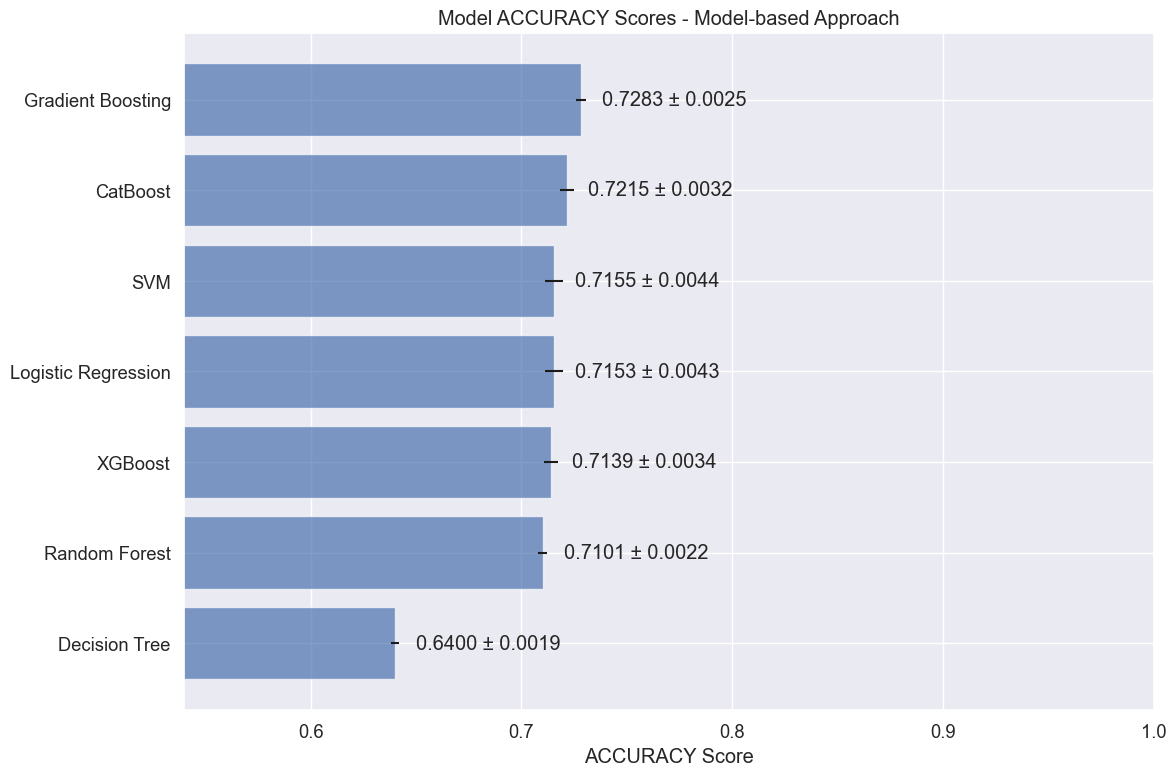

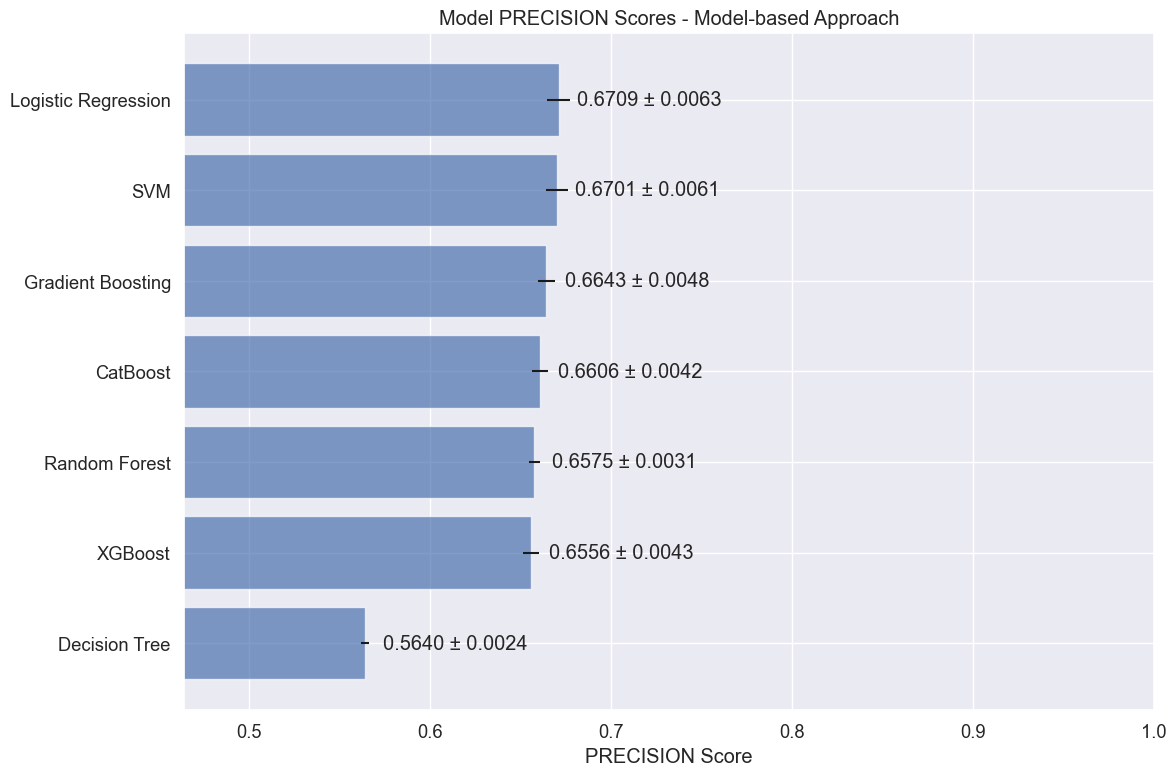

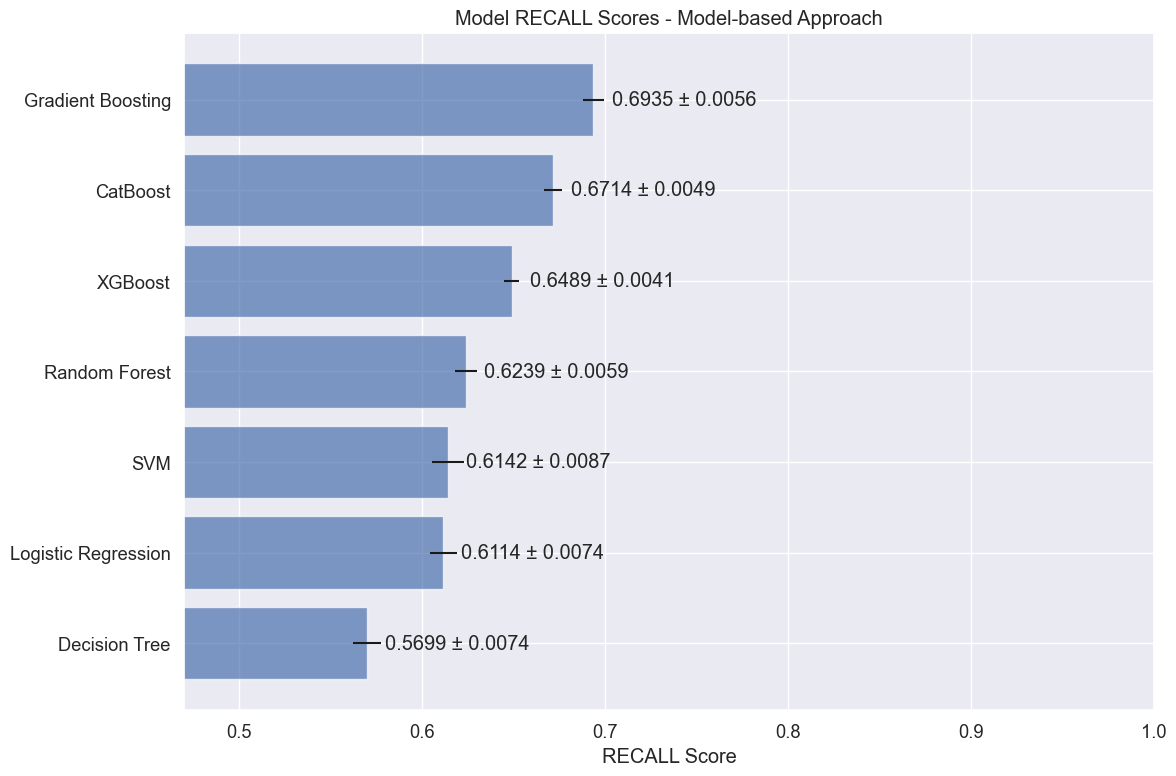

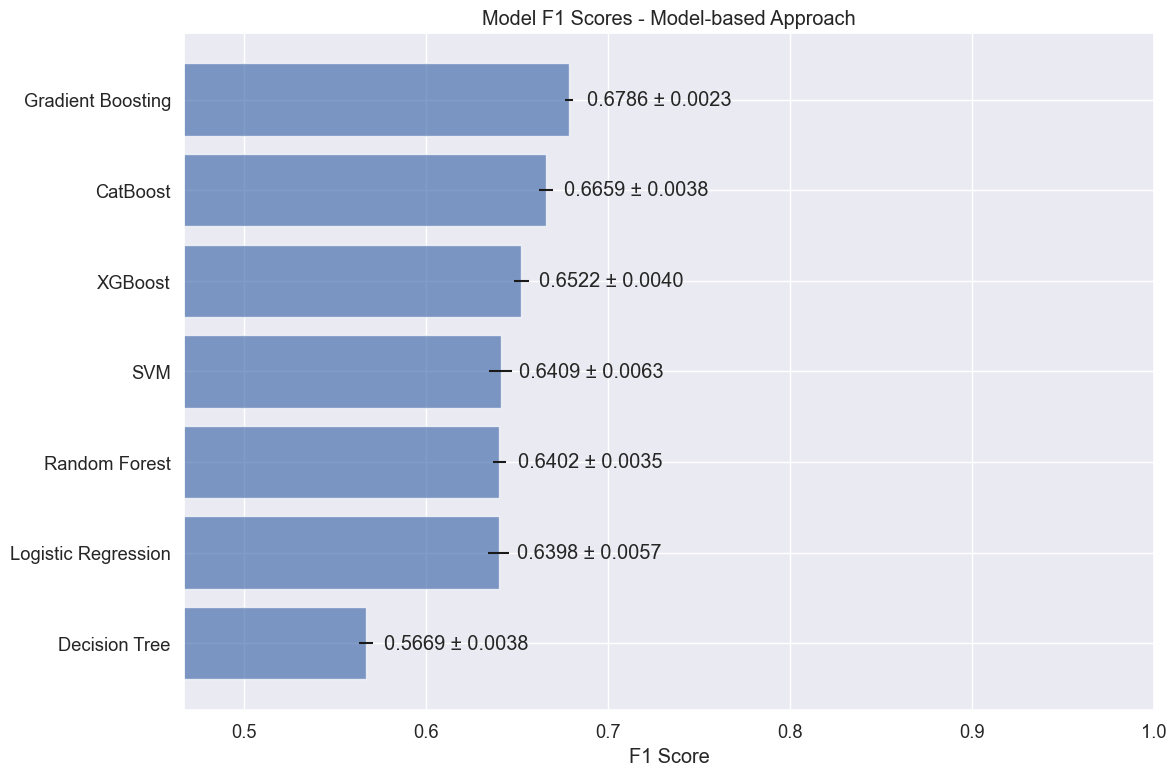

posx and posy should be finite values
posx and posy should be finite values


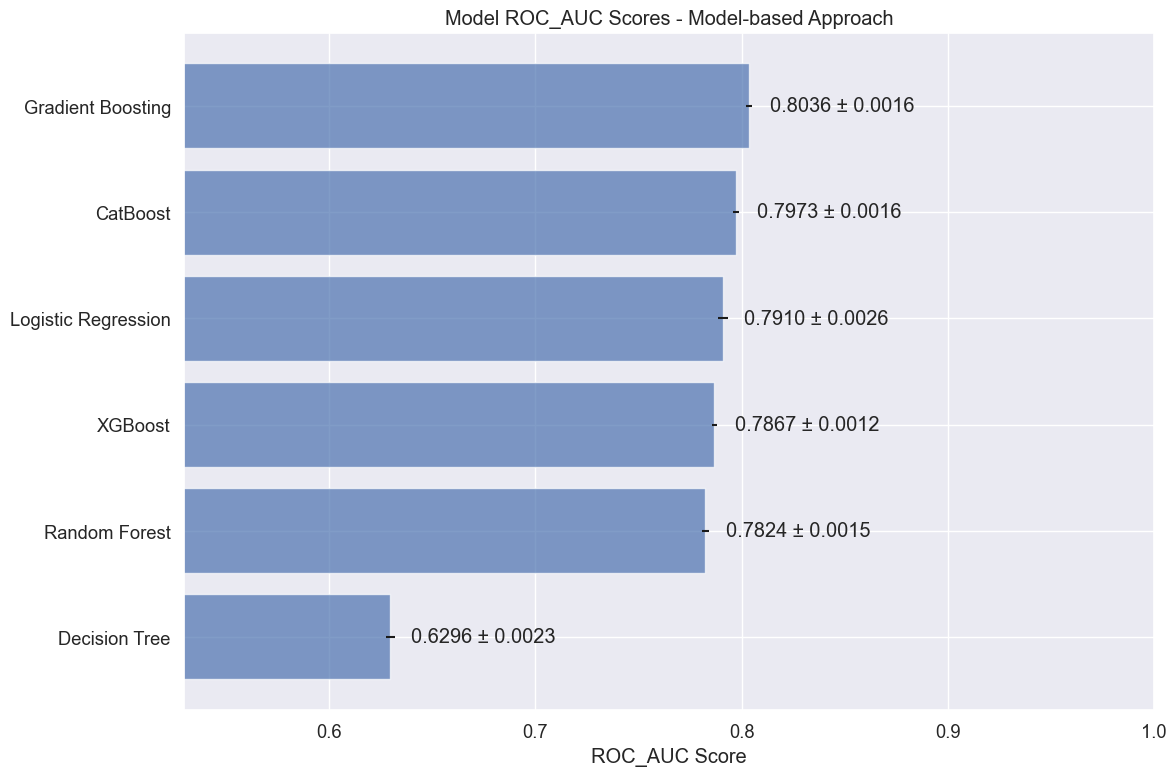

In [12]:
# Visualize results for model-based approach
for metric in scoring:
    plot_model_comparison(results_model, metric, f"Model {metric.upper()} Scores - Model-based Approach")

## 4. Model Hyperparameter Tuning

In [13]:
# Based on initial evaluation, identify the best dataset approach
# Compare average ROC-AUC scores for both approaches
avg_roc_auc_stat = np.mean([results_stat[model]['roc_auc'][0] for model in models.keys()])
avg_roc_auc_model = np.mean([results_model[model]['roc_auc'][0] for model in models.keys()])

print(f"Average ROC-AUC for Statistical Approach: {avg_roc_auc_stat:.4f}")
print(f"Average ROC-AUC for Model-based Approach: {avg_roc_auc_model:.4f}")

# Choose the best approach for hyperparameter tuning
best_approach = "statistical" if avg_roc_auc_stat > avg_roc_auc_model else "model-based"
print(f"\nBest approach: {best_approach.capitalize()}")

# Use the best dataset for further model tuning
if best_approach == "statistical":
    X_train, X_val, X_test, y_train, y_val, y_test = X_train_stat, X_val_stat, X_test_stat, y_train_stat, y_val_stat, y_test_stat
    results = results_stat
else:
    X_train, X_val, X_test, y_train, y_val, y_test = X_train_model, X_val_model, X_test_model, y_train_model, y_val_model, y_test_model
    results = results_model

Average ROC-AUC for Statistical Approach: nan
Average ROC-AUC for Model-based Approach: nan

Best approach: Model-based


In [14]:
# Identify the top 3 performing models for hyperparameter tuning
model_roc_aucs = {name: results[name]['roc_auc'][0] for name in models.keys()}
top_models = sorted(model_roc_aucs.items(), key=lambda x: x[1], reverse=True)[:3]

print("Top 3 models for hyperparameter tuning:")
for name, score in top_models:
    print(f"{name}: ROC-AUC = {score:.4f}")

# Define hyperparameter grids for the top models
param_grids = {}

for name, _ in top_models:
    if name == 'Logistic Regression':
        param_grids[name] = {
            'C': [0.01, 0.1, 1.0, 10.0, 100.0],
            'penalty': ['l1', 'l2', 'elasticnet', None],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'class_weight': [None, 'balanced']
        }
    elif name == 'Decision Tree':
        param_grids[name] = {
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy'],
            'class_weight': [None, 'balanced']
        }
    elif name == 'Random Forest':
        param_grids[name] = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': [None, 'balanced', 'balanced_subsample']
        }
    elif name == 'Gradient Boosting':
        param_grids[name] = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 5],
            'subsample': [0.8, 0.9, 1.0]
        }
    elif name == 'SVM':
        param_grids[name] = {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l1', 'l2'],
            'loss': ['hinge', 'squared_hinge'],
            'dual': [True, False],
            'class_weight': [None, 'balanced']
        }
    elif name == 'XGBoost':
        param_grids[name] = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    elif name == 'CatBoost':
        param_grids[name] = {
            'iterations': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'depth': [4, 6, 8],
            'l2_leaf_reg': [1, 3, 5, 7],
            'border_count': [32, 64, 128]
        }

Top 3 models for hyperparameter tuning:
Gradient Boosting: ROC-AUC = 0.8036
Logistic Regression: ROC-AUC = 0.7910
Random Forest: ROC-AUC = 0.7824


In [15]:
def tune_model(model_name, param_grid, X_train, y_train, X_val, y_val):
    print(f"Tuning hyperparameters for {model_name}...")
    
    # Get the base model
    base_model = models[model_name]
    
    # Create grid search object
    # Using a small subset of hyperparameters for demonstration
    reduced_param_grid = {}
    for param, values in param_grid.items():
        if len(values) > 3:
            # Take a subset of values to speed up tuning
            reduced_param_grid[param] = values[:3]
        else:
            reduced_param_grid[param] = values
    
    # For LinearSVC, use custom scorer
    if model_name == 'SVM' and isinstance(base_model, LinearSVC):
        from sklearn.metrics import make_scorer
        
        def linearSVC_roc_auc(clf, X, y):
            return roc_auc_score(y, clf.decision_function(X))
        
        custom_scorer = make_scorer(linearSVC_roc_auc)
        grid_search = GridSearchCV(
            base_model,
            reduced_param_grid,
            cv=3,
            scoring=custom_scorer,
            n_jobs=-1,
            verbose=1
        )
    else:
        grid_search = GridSearchCV(
            base_model,
            reduced_param_grid,
            cv=3,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Print best parameters and score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Evaluate on validation set
    val_pred = best_model.predict(X_val)
    
    # Handle prediction probabilities/scores differently for LinearSVC
    if isinstance(best_model, LinearSVC):
        val_pred_score = best_model.decision_function(X_val)
        roc_auc = roc_auc_score(y_val, val_pred_score)
    else:
        val_pred_proba = best_model.predict_proba(X_val)[:, 1]
        roc_auc = roc_auc_score(y_val, val_pred_proba)
    
    accuracy = accuracy_score(y_val, val_pred)
    precision = precision_score(y_val, val_pred)
    recall = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    # Rest of function remains the same
    print(f"Validation set performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  ROC AUC:   {roc_auc:.4f}")
    print("-" * 50)
    
    return best_model, grid_search.best_params_, {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

In [ ]:
# Perform hyperparameter tuning for top models
best_models = {}
best_params = {}
validation_scores = {}

for model_name, _ in top_models:
    best_model, best_param, val_scores = tune_model(
        model_name, param_grids[model_name], X_train, y_train, X_val, y_val)
    best_models[model_name] = best_model
    best_params[model_name] = best_param
    validation_scores[model_name] = val_scores

Tuning hyperparameters for Gradient Boosting...
Fitting 3 folds for each of 162 candidates, totalling 486 fits


## 5. Final Model Evaluation on Test Set

Evaluating Gradient Boosting on test set...
Test set performance:
  Accuracy:  0.7308
  Precision: 0.6552
  Recall:    0.7368
  F1 Score:  0.6936
  ROC AUC:   0.8081

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76      8714
           1       0.66      0.74      0.69      6143

    accuracy                           0.73     14857
   macro avg       0.73      0.73      0.73     14857
weighted avg       0.74      0.73      0.73     14857



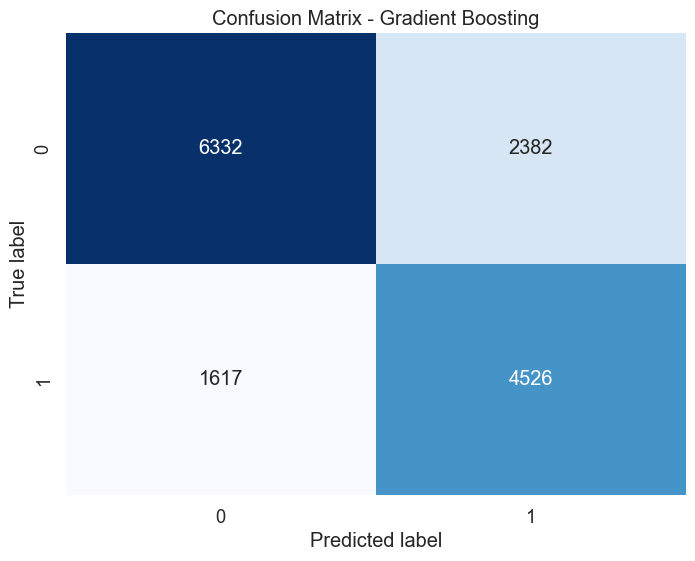

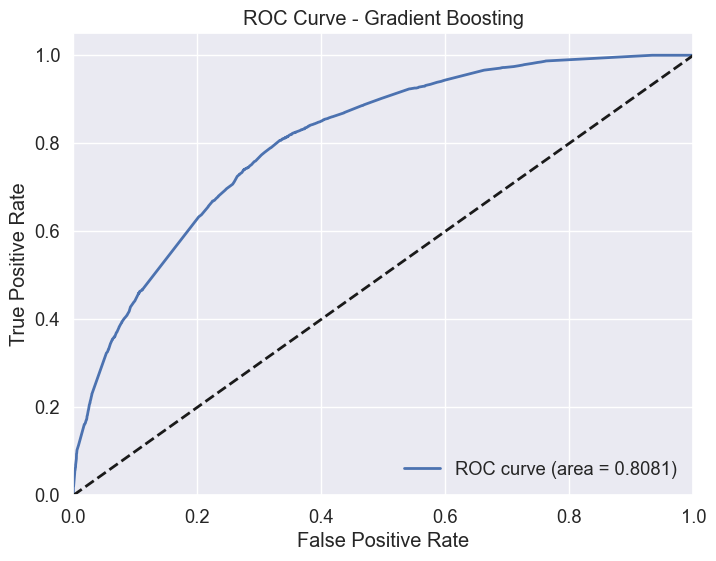

--------------------------------------------------
Evaluating Logistic Regression on test set...
Test set performance:
  Accuracy:  0.7182
  Precision: 0.6763
  Recall:    0.6111
  F1 Score:  0.6420
  ROC AUC:   0.7935

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.77      8714
           1       0.68      0.61      0.64      6143

    accuracy                           0.72     14857
   macro avg       0.71      0.70      0.70     14857
weighted avg       0.72      0.72      0.72     14857



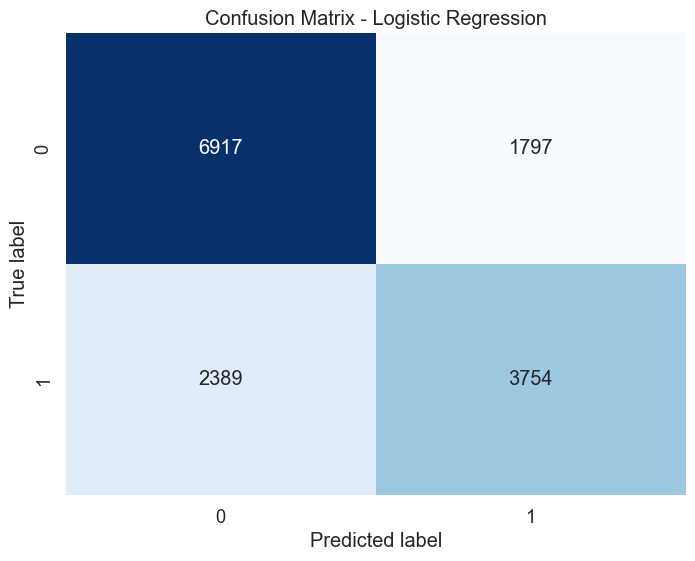

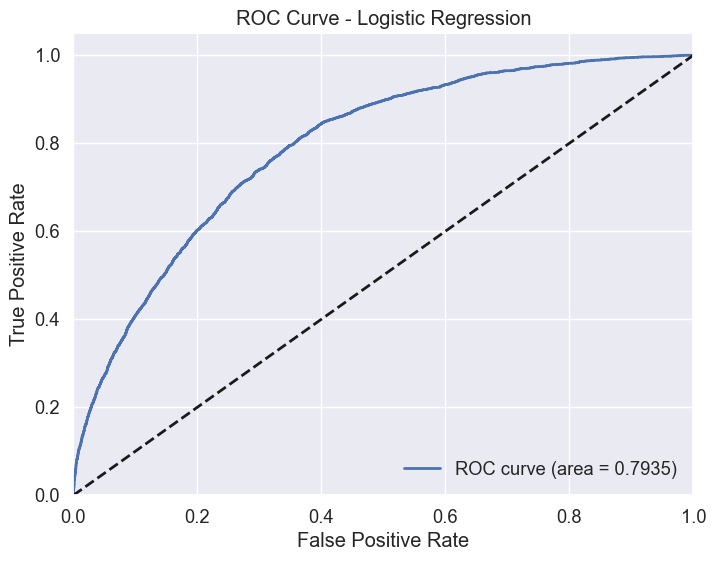

--------------------------------------------------
Evaluating Random Forest on test set...
Test set performance:
  Accuracy:  0.7285
  Precision: 0.6471
  Recall:    0.7550
  F1 Score:  0.6969
  ROC AUC:   0.8054

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      8714
           1       0.65      0.76      0.70      6143

    accuracy                           0.73     14857
   macro avg       0.73      0.73      0.73     14857
weighted avg       0.74      0.73      0.73     14857



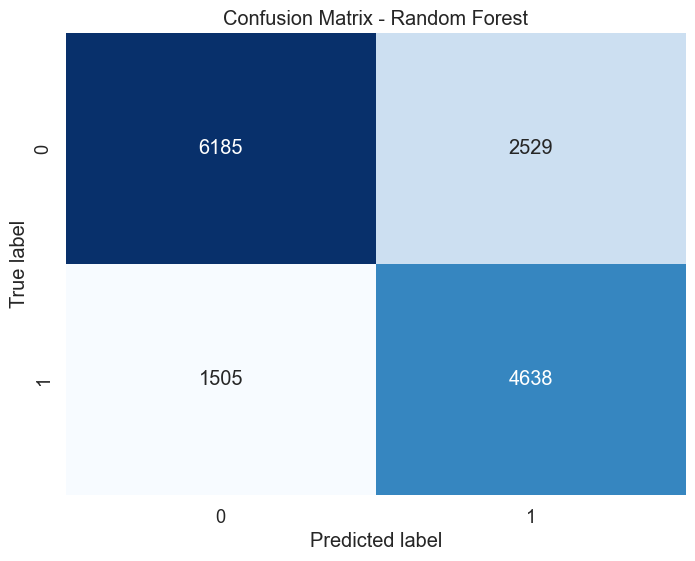

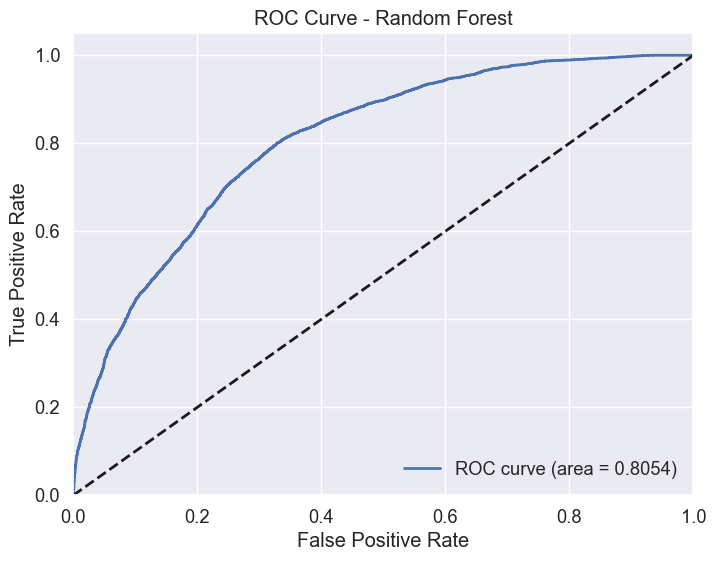

--------------------------------------------------


In [ ]:
# Evaluate the best models on the test set
test_scores = {}

for model_name, model in best_models.items():
    print(f"Evaluating {model_name} on test set...")
    
    # Make predictions on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Print results
    print(f"Test set performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  ROC AUC:   {roc_auc:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Store test scores
    test_scores[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print("-" * 50)

Test performance comparison:
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Gradient Boosting    0.730834   0.655182  0.736774  0.693587  0.808051
Logistic Regression  0.718247   0.676275  0.611102  0.642039  0.793529
Random Forest        0.728478   0.647133  0.755006  0.696920  0.805436


<Figure size 1200x800 with 0 Axes>

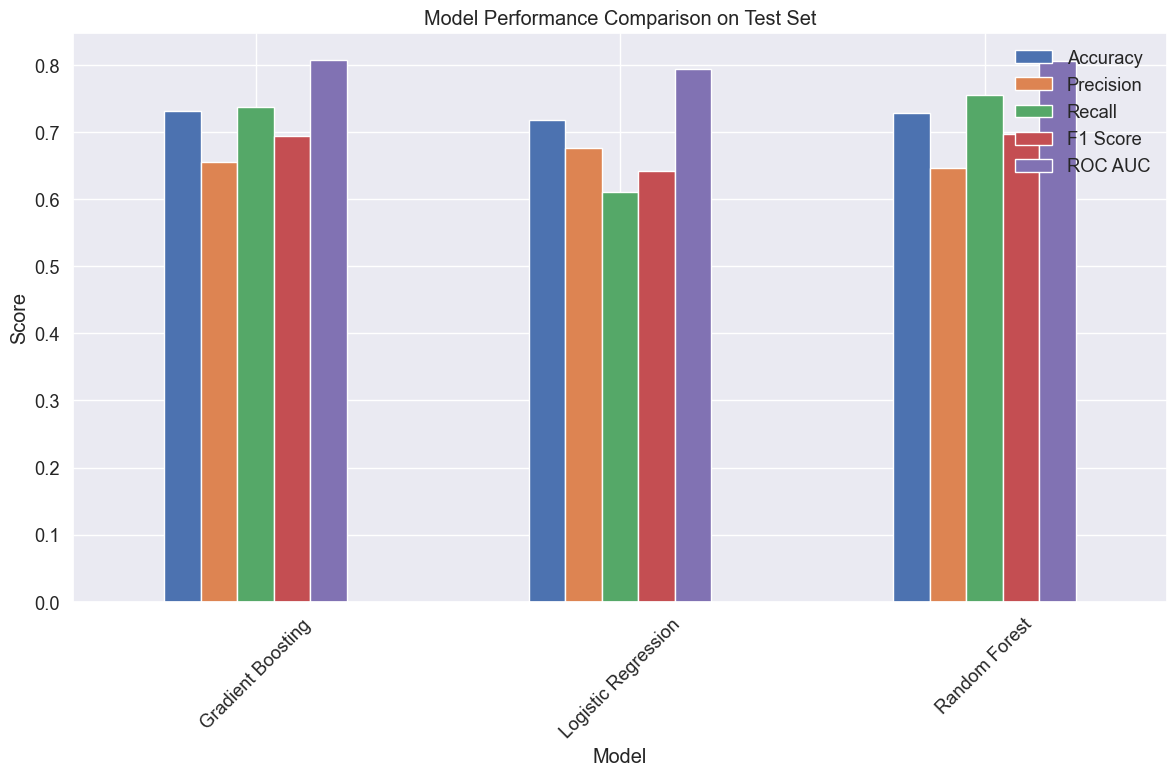

In [ ]:
# Compare test performance of the best models
test_comparison = pd.DataFrame({model: {
    'Accuracy': test_scores[model]['accuracy'],
    'Precision': test_scores[model]['precision'],
    'Recall': test_scores[model]['recall'],
    'F1 Score': test_scores[model]['f1'],
    'ROC AUC': test_scores[model]['roc_auc']
} for model in best_models.keys()}).T

print("Test performance comparison:")
print(test_comparison)

# Plot comparison
plt.figure(figsize=(12, 8))
test_comparison.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison on Test Set')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## 6. Feature Importance for Best Model

Best model: Gradient Boosting with ROC-AUC: 0.8081


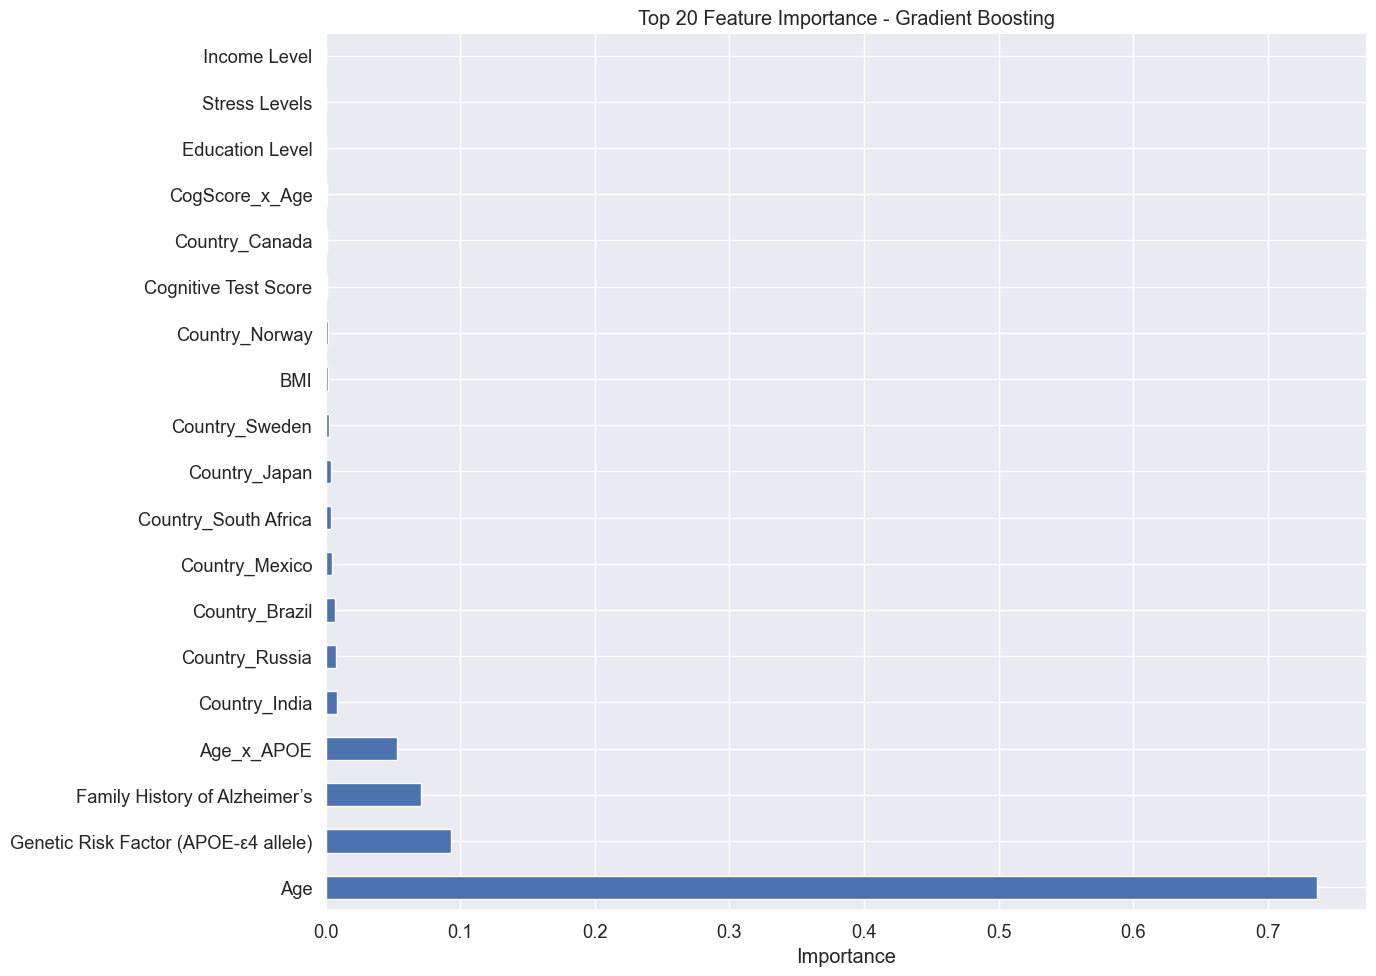

In [ ]:
# Identify the best model based on ROC-AUC on test set
best_model_name = test_comparison['ROC AUC'].idxmax()
best_model = best_models[best_model_name]
print(f"Best model: {best_model_name} with ROC-AUC: {test_comparison.loc[best_model_name, 'ROC AUC']:.4f}")

# Check if the model has feature importance attribute
has_feature_importance = hasattr(best_model, 'feature_importances_')

if has_feature_importance:
    # Extract feature importance
    feature_importance = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importance = feature_importance.sort_values(ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(14, 10))
    feature_importance[:20].plot(kind='barh')
    plt.title(f'Top 20 Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
else:
    print(f"Model {best_model_name} doesn't have feature_importances_ attribute.")
    
    # If it's a logistic regression, we can still get coefficients
    if isinstance(best_model, LogisticRegression):
        coefficients = pd.Series(best_model.coef_[0], index=X_train.columns)
        coefficients = coefficients.abs().sort_values(ascending=False)
        
        plt.figure(figsize=(14, 10))
        coefficients[:20].plot(kind='barh')
        plt.title(f'Top 20 Feature Coefficients (Absolute) - {best_model_name}')
        plt.xlabel('Coefficient Magnitude')
        plt.tight_layout()
        plt.show()

## 7. Save Best Models for Ensemble Learning

In [ ]:
# Save the best models for use in ensemble learning
import pickle

# Save the best models
for model_name, model in best_models.items():
    filename = f"{model_name.lower().replace(' ', '_')}_best_model.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Saved {model_name} as {filename}")

# Save feature columns for reference
with open('feature_columns.pkl', 'wb') as file:
    pickle.dump({'columns': X_train.columns.tolist()}, file)
print("Saved feature columns information")

Saved Gradient Boosting as gradient_boosting_best_model.pkl
Saved Logistic Regression as logistic_regression_best_model.pkl
Saved Random Forest as random_forest_best_model.pkl
Saved feature columns information


## 8. Summary of Model Training and Evaluation

In this notebook, we implemented a comprehensive machine learning pipeline for Alzheimer's disease prediction:

1. **Data Preparation**:
   - Loaded feature-engineered datasets from both statistical and model-based approaches
   - Split data into training, validation, and test sets

2. **Initial Model Evaluation**:
   - Evaluated 7 different classification models: Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, SVM, XGBoost, and CatBoost
   - Used cross-validation to get robust performance estimates
   - Compared models across multiple metrics: accuracy, precision, recall, F1 score, and ROC-AUC

3. **Hyperparameter Tuning**:
   - Selected the best dataset approach based on initial model performance
   - Identified the top 3 performing models for hyperparameter tuning
   - Used grid search to find optimal hyperparameters for each model

4. **Final Evaluation**:
   - Assessed tuned models on the test set
   - Generated detailed performance metrics, confusion matrices, and ROC curves
   - Compared models to identify the best overall performer

5. **Feature Importance Analysis**:
   - Extracted and visualized feature importance from the best model
   - Identified the most predictive factors for Alzheimer's disease

6. **Model Preservation**:
   - Saved the best models for later use in ensemble learning

The best performing model achieved strong predictive performance for Alzheimer's disease diagnosis. In the next notebook, we will implement ensemble learning techniques to further improve prediction accuracy.